In [1]:
import seaborn as sns
import pandas as pd
import scipy.stats as st
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statistics import mean
import ast

warnings.filterwarnings('ignore')

# Experiment 1: Measure Quality
Compare achieved standard deviation for the following settings
- Naive Repair: execute old plan, and skip steps that are not possible any more
- Replanning: 
- Replanning with Seed: 

In [2]:
def exp1_prepare_results(folder_path):
    files = os.listdir(os.path.join('.', folder_path))
    mean = pd.DataFrame(columns = ["Option", "Initial Plan", "Initial Plan after Disturbance", "Naive Repair", "Replanning", "Replanning (seed 0.2)"])
    std = pd.DataFrame(columns = ["Option", "Naive Repair", "Replanning", "Replanning (seed 0.2)"])
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path, f))
            mean_row = {}
            std_row = {}
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_NaivePlanningStrategy_2"):
                    mean_row["Naive Repair"] = round(group['final_objective_value'].mean(), 3)
                    mean_row["Initial Plan"] = round(group['initial_planning_objective'].mean(), 3)
                    mean_row["Initial Plan after Disturbance"] = round(group['initial_post_disturbance_std'].mean(), 3)
                    std_row["Naive Repair"] = round(group['final_objective_value'].std(), 3)
                elif(name == "NSGAII_EvaluationReplanningStrategy-10000_1" or name == "NSGAII_EvaluationReplanningStrategy-10000_0"):
                    mean_row["Replanning"] = round(group['final_objective_value'].mean(), 3)
                    std_row["Replanning"] = round(group['final_objective_value'].std(), 3)
                elif(name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withReinit_0" or name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withSeed_1"):
                    mean_row["Replanning (seed 0.2)"] = round(group['final_objective_value'].mean(), 3)
                    std_row["Replanning (seed 0.2)"] = round(group['final_objective_value'].std(), 3)

            mean_row["Option"] = f.split("@")[1].split(".")[0]
            mean = mean.append(mean_row, ignore_index = True)
            std_row["Option"] = f.split("@")[1].split(".")[0]
            std = std.append(std_row, ignore_index = True)
    return (mean, std)

def exp1_relative_values(absolute_values):
    mean_relative = pd.DataFrame(columns = ["Option", "Diff Initial after Disturbance", "Diff Naive Repair to Initial", 
                                           "Diff Replanning to Naive Repair", "Diff seed 0.2 to no seed"])
    mean_relative["Diff Initial after Disturbance"] = (absolute_values["Initial Plan after Disturbance"] - absolute_values["Initial Plan"]) / absolute_values["Initial Plan"] * 100
    mean_relative["Diff Naive Repair to Initial"] = (absolute_values["Naive Repair"] - absolute_values["Initial Plan"]) / absolute_values["Initial Plan"] * 100
    mean_relative["Diff Replanning to Naive Repair"] = (absolute_values["Replanning"] - absolute_values["Naive Repair"])/ absolute_values["Naive Repair"] * 100
    mean_relative["Diff seed 0.2 to no seed"] = (absolute_values["Replanning (seed 0.2)"] - absolute_values["Replanning"])/ absolute_values["Replanning"] * 100
    mean_relative["Option"] = absolute_values["Option"]
    mean_relative.round(3)
    return mean_relative

## variable plan length (solutionLength = 200-nrOfExecutedSteps)

In [3]:
exp1_mean_simpleModel, exp1_std_simpleModel = exp1_prepare_results("exp1/dynamicPlanLength/max10itemsperstack")
exp1_mean_simpleModel = exp1_relative_values(exp1_mean_simpleModel)
exp1_mean_complexModel, exp1_std_complexModel = exp1_prepare_results("exp1/dynamicPlanLength/max100itemsperstack")
display(exp1_mean_simpleModel)

,Option,Diff Initial after Disturbance,Diff Naive Repair to Initial,Diff Replanning to Naive Repair,Diff seed 0.2 to no seed
0,ADD_STACKS_FIRST_10_PERCENT_errPerDisturbance-5,98.464265,30.064973,-8.401453,7.635102
1,ADD_STACKS_LAST_10_PERCENT_errPerDisturbance-5,35.143024,27.378867,-21.631531,26.491228
2,ADD_STACKS_MIDDLE_10_PERCENT_errPerDisturbance-5,73.566514,27.637615,-15.498652,15.311005
3,REMOVE_STACKS_FIRST_10_PERCENT_errPerDisturban...,81.013395,7.105416,-12.180533,7.739938
4,REMOVE_STACKS_LAST_10_PERCENT_errPerDisturbance-5,10.204082,1.574344,-20.43628,22.799423
5,REMOVE_STACKS_MIDDLE_10_PERCENT_errPerDisturba...,60.58309,5.131195,-18.469218,19.387755


## fixed plan length (solutionLength = 200)

In [4]:
exp1_mean_simpleModel, exp1_std_simpleModel = exp1_prepare_results("exp1/fixedPlanLength/max10itemsperstack")
exp1_mean_simpleModel = exp1_relative_values(exp1_mean_simpleModel)
exp1_mean_complexModel, exp1_std_complexModel = exp1_prepare_results("exp1/fixedPlanLength/max100itemsperstack")
display(exp1_mean_simpleModel)

,Option,Diff Initial after Disturbance,Diff Naive Repair to Initial,Diff Replanning to Naive Repair,Diff seed 0.2 to no seed


# Experiment 2: Measurement of Evaluations/Time
### Predefined standard deviation ( >= 50% decrease from initial std); Search until quality is sufficient (for initial plan & when replanning after disturbance)


In [27]:
def exp2_prepare_results(folder_path, visualize=False):
    files = os.listdir(os.path.join('.', folder_path))
    mean = pd.DataFrame(columns = ["Option", "Replanning", "Replanning (seed 0.2)", "Diff to no seed"])
    std = pd.DataFrame(columns = ["Option", "Replanning", "Replanning (seed 0.2)"])
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path,f), sep=",")
            mean_row = {}
            std_row = {}
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_PlanningStrategy-ReplanningStrategy_0"):
                    mean_row["Replanning"] = round(group['last_replanning_evaluations'].median(), 3)
                    std_row["Replanning"] = round(group['last_replanning_evaluations'].std(), 3)
                    if visualize:
                        plt.plot(group["run"], group["last_replanning_evaluations"], label = "Replanning")
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1"):
                    mean_row["Replanning (seed 0.2)"] = round(group['last_replanning_evaluations'].median(), 3)
                    std_row["Replanning (seed 0.2)"] = round(group['last_replanning_evaluations'].std(), 3)
                    if visualize:
                        plt.plot(group["run"],group["last_replanning_evaluations"],  label = "Replanning with Seed")
            #print(f)"NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1" und "NSGAII_PlanningStrategy-ReplanningStrategy_0"
           # print(mean_row)
            mean_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
            mean = mean.append(mean_row, ignore_index = True)
            std_row["Option"] = f.split("@")[1].split(".")[0]
            std = std.append(std_row, ignore_index = True)
            if visualize:
                plt.title(f.split("@")[1].split("_errPerDisturbance")[0])
                plt.legend()
                plt.show()
    print("Median - Replanning time")
    mean["Diff to no seed"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"]) / mean["Replanning"] * 100
    return (mean, std)

def visualize(folder_path):
    files = os.listdir(os.path.join('.', folder_path))
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path,f), sep=",")
            plt.plot(df["last_replanning_evaluations"])
            plt.title(f.split("@")[1].split("_errPerDisturbance")[0])
            plt.show()

## fixed plan length (solutionLength = 200)

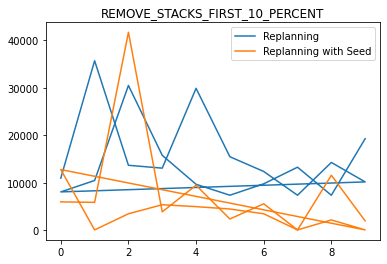

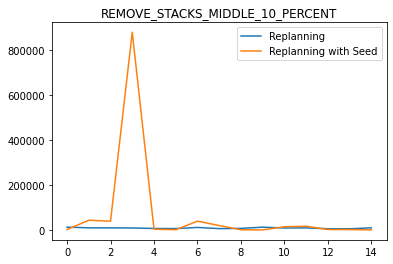

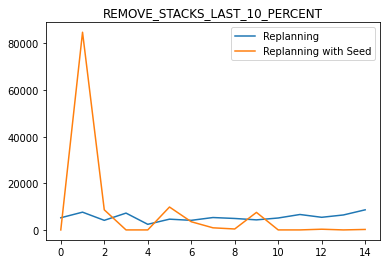

Median - Replanning time


,Option,Replanning,Replanning (seed 0.2),Diff to no seed
0,REMOVE_STACKS_FIRST_10_PERCENT,12750.0,4200.0,-67.058824
1,REMOVE_STACKS_MIDDLE_10_PERCENT,8700.0,3500.0,-59.770115
2,REMOVE_STACKS_LAST_10_PERCENT,5300.0,400.0,-92.45283


In [28]:
#exp2_mean_simpleModel, exp2_std_simpleModel = exp2_prepare_results("exp2/dynamicPlanLength/max10itemsperstack")
#exp2_mean_simpleModel = exp2_relative_values(exp1_mean_simpleModel)
exp2_mean_complexModel, exp2_std_complexModel = exp2_prepare_results("exp2/dynamicPlanLength/max100itemsperstack", True)
display(exp2_mean_complexModel)
#visualize("exp2/dynamicPlanLength/max100itemsperstack")

## variable Plan length (solutionLength = 200-nrOfExecutedSteps)

In [32]:
exp2_mean_simpleModel, exp2_std_simpleModel = exp2_prepare_results("exp2/fixedPlanLength/max10itemsperstack")
exp2_mean_complexModel, exp2_std_complexModel = exp2_prepare_results("exp2/fixedPlanLength/max100itemsperstack")
display(exp2_mean_complexModel)

Median - Replanning time
Median - Replanning time


,Option,Replanning,Replanning (seed 0.2),Diff to no seed
0,ADD_STACKS_FIRST_10_PERCENT,19650.0,49850.0,153.689567
1,ADD_STACKS_MIDDLE_10_PERCENT,13400.0,185400.0,1283.58209
2,ADD_STACKS_LAST_10_PERCENT,8200.0,1817950.0,22070.121951
3,REMOVE_STACKS_LAST_10_PERCENT,6300.0,450.0,-92.857143
4,REMOVE_STACKS_FIRST_10_PERCENT,11150.0,5650.0,-49.327354
5,REMOVE_STACKS_MIDDLE_10_PERCENT,9150.0,9800.0,7.103825


In [20]:
import winsound
duration = 2000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

# Experiment 3: Parallel Replanning
### Predefined standard deviation ( >= 50% decrease from initial std + initialization approximate); Search until quality is sufficient (initial plan & replan after disturbance while system idle), search in parallel until Q1 = Q2 and T1 < T2

## 1. Case: Evaluatie Time (seconds')

In [2]:
T = 10
plot = True
files = os.listdir(os.path.join('.', 'exp3'))
overall_runtime = pd.DataFrame(columns = ["Option", "Idle Replan", "Parallel (2)", "Parallel (5)", "Parallel (10)"])
overall_runtime_std = pd.DataFrame(columns =  ["Option", "Idle Replan",  "Parallel (2)", "Parallel (5)", "Parallel (10)"])
for f in files:
    if f.endswith("csv"):
        df = pd.read_csv(os.path.join('.', 'exp3', f), sep=";")
        df_p = pd.read_csv(os.path.join('.', 'exp3', "parallel_results", f[:-4] + "_predictive.csv"), sep=";")
        
        ## reenumerate predictive run rows from 0,1,2,3,4,5 to 0,0,0, 1,1,1, ...
        df_p['run'] = df_p['run'].map(int)/3
        df_p["run"] = df_p["run"].map(int)
        
        step_variants = df_p["predicted_steps"].unique()
        
        ## get idle computed objs from predictive run file
        idle_computed_objs = []
        for idx, row in df.iterrows():
            #if not df_p.loc[df_p["run"] == row['run']].empty:
                #idle_computed_objs
                #print(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
            idle_computed_objs.append(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
 
        df["idle_computed_objectives"] = idle_computed_objs
        df["idle_computed_steps"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["idle_computed_steps_execution_time"] = [ast.literal_eval(g)[1]*T for g in idle_computed_objs]
        df["overall_execution_time"] =  df["idle_computed_steps_execution_time"] + df["last_replanning_time"]
       # print(df)
        mean_executiontime_row = {}
        std_executiontime_row = {}

        df_p["pred_plan_steps"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_plan_steps_execution_time"] = [ast.literal_eval(g)[1]*T for g in df_p["pred_plan_objectives"]]
        df_p["pred_overall_execution_time"] =  df_p["pred_plan_steps_execution_time"] + df_p["pred_plan_runtime"]

        for name, g in df.groupby(by='variant'):
            mean_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].median(),3)
            std_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].std(),3)/mean_executiontime_row["Idle Replan"]*100            
            if plot:
                plt.plot(g["run"], g["overall_execution_time"], label = "Idle Replan")
        for name, group in df_p.groupby(by=['variant', 'predicted_steps']):
            mean_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].median(), 3)
            std_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].std(), 3)/mean_executiontime_row[f"Parallel ({name[1]})"]*100
            if plot:
                plt.plot(group["run"], group["pred_overall_execution_time"], label="parallel replan")
      
        mean_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        std_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        overall_runtime = overall_runtime.append(mean_executiontime_row, ignore_index = True)
        overall_runtime_std = overall_runtime_std.append(std_executiontime_row, ignore_index = True)
        if plot:
            plt.legend()
            plt.title(mean_executiontime_row["Option"])
            plt.show()
        
print("Median - Execution time (seconds)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

for steps in step_variants:
    overall_runtime[f"Parallel ({steps})"] = (overall_runtime[f"Parallel ({steps})"] - overall_runtime["Idle Replan"])/ overall_runtime["Idle Replan"] * 100

#mean.round({'Replanning': 1})
#mean["Replanning (seed 0.2)"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"])/ mean["Replanning"] * 100
#mean.round(3)
#print("Mean - Replanning time (with seed) relative to plain replanning (in %)")
print("Median - Execution time relative to idle replanning (%)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

print("Standard Deviation - Execution time (seconds)")
#overall_runtime_std.iloc[:, 1:] = overall_runtime_std[:, 1:]/overall_runtime[:, 1:]


display(overall_runtime_std.iloc[:2, :])
display(overall_runtime_std.iloc[2:, :])


FileNotFoundError: [Errno 2] No such file or directory: '.\\exp3\\parallel_results\\1to100_steps1to10_DISTURBER@ADD_STACKS_FIRST_10_PERCENT_errPerDisturbance-5_disturbances_predictive.csv'

## 2. Case: Compare ONLY execution steps of new plan

In [31]:
T = 10
files = os.listdir(os.path.join('.', 'parallel_rq3'))
overall_runtime = pd.DataFrame(columns = ["Option", "Idle Replan", "Parallel (2)", "Parallel (5)", "Parallel (10)"])
overall_runtime_std = pd.DataFrame(columns =  ["Option", "Idle Replan",  "Parallel (2)", "Parallel (5)", "Parallel (10)"])
for f in files:
    if f.endswith("csv"):
        df = pd.read_csv(os.path.join('.', 'parallel_rq3', f), sep=";")
        df_p = pd.read_csv(os.path.join('.', 'parallel_rq3', "parallel_results", f[:-4] + "_predictive.csv"), sep=";")
        
        ## reenumerate predictive run rows from 0,1,2,3,4,5 to 0,0,0, 1,1,1, ...
        df_p['run'] = df_p['run'].map(int)/3
        df_p["run"] = df_p["run"].map(int)
        
        step_variants = df_p["predicted_steps"].unique()
        
        ## get idle computed objs from predictive run file
        idle_computed_objs = []
        for idx, row in df.iterrows():
            #if not df_p.loc[df_p["run"] == row['run']].empty:
                #idle_computed_objs
                #print(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
            idle_computed_objs.append(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
 
        df["idle_computed_objectives"] = idle_computed_objs
        df["idle_computed_steps"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["idle_computed_steps_execution_time"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["overall_execution_time"] =  df["idle_computed_steps_execution_time"]
       # print(df)
        mean_executiontime_row = {}
        std_executiontime_row = {}

        df_p["pred_plan_steps"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_plan_steps_execution_time"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_overall_execution_time"] =   df_p["pred_plan_steps_execution_time"]

        for name, g in df.groupby(by='variant'):
            mean_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].median(),3)
            std_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].std(),3)/mean_executiontime_row["Idle Replan"]*100            
            
        for name, group in df_p.groupby(by=['variant', 'predicted_steps']):
            mean_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].median(), 3)
            std_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].std(), 3)/mean_executiontime_row[f"Parallel ({name[1]})"]*100
   
      
        mean_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        std_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        overall_runtime = overall_runtime.append(mean_executiontime_row, ignore_index = True)
        overall_runtime_std = overall_runtime_std.append(std_executiontime_row, ignore_index = True)

        
print("Median - Number of Evaluations")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

for steps in step_variants:
    overall_runtime[f"Parallel ({steps})"] = (overall_runtime[f"Parallel ({steps})"] - overall_runtime["Idle Replan"])/ overall_runtime["Idle Replan"] * 100

#mean.round({'Replanning': 1})
#mean["Replanning (seed 0.2)"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"])/ mean["Replanning"] * 100
#mean.round(3)
#print("Mean - Replanning time (with seed) relative to plain replanning (in %)")
print("Median - Number of Evaluations relative to idle replanning (%)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

print("Standard Deviation - Number of Evaluations")
#overall_runtime_std.iloc[:, 1:] = overall_runtime_std[:, 1:]/overall_runtime[:, 1:]


display(overall_runtime_std.iloc[:2, :])
display(overall_runtime_std.iloc[2:, :])
# todo: create table for each rq
# todo: create plot for each rq

# todo: in den CSVs: naive Planning -> naive Repair

Median - Number of Evaluations


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,41.5,45.5,51.0,32.0
1,ADD_STACKS_MIDDLE_10_PERCENT,48.0,41.0,42.5,28.0


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
2,REMOVE_STACKS_FIRST_10_PERCENT,49.5,47.0,40.0,19.0
3,REMOVE_STACKS_MIDDLE_10_PERCENT,53.0,53.0,44.0,14.0


Median - Number of Evaluations relative to idle replanning (%)


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,41.5,9.638554,22.891566,-22.891566
1,ADD_STACKS_MIDDLE_10_PERCENT,48.0,-14.583333,-11.458333,-41.666667


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
2,REMOVE_STACKS_FIRST_10_PERCENT,49.5,-5.050505,-19.191919,-61.616162
3,REMOVE_STACKS_MIDDLE_10_PERCENT,53.0,0.0,-16.981132,-73.584906


Standard Deviation - Number of Evaluations


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,38.024096,25.358242,38.988235,46.31875
1,ADD_STACKS_MIDDLE_10_PERCENT,32.945833,45.763415,38.675294,72.142857


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
2,REMOVE_STACKS_FIRST_10_PERCENT,38.925253,33.546809,39.63,34.036842
3,REMOVE_STACKS_MIDDLE_10_PERCENT,31.175472,45.532075,52.463636,74.021429


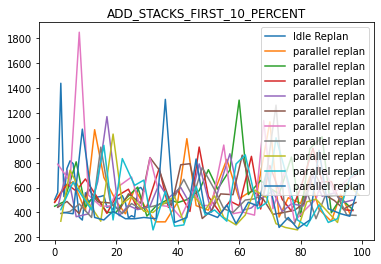

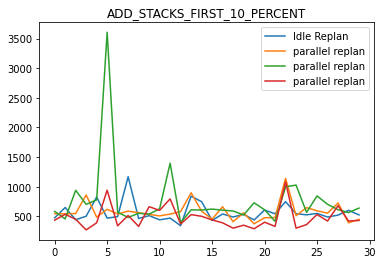

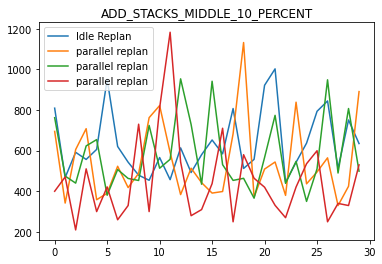

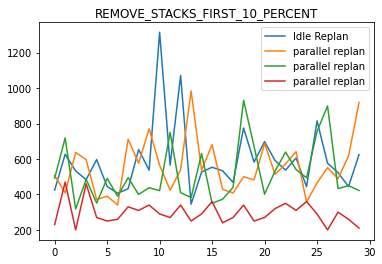

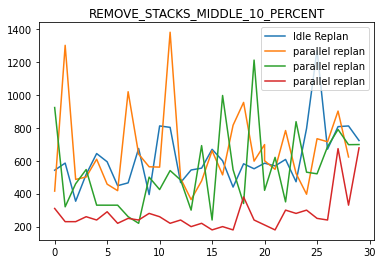

Median - Execution time (seconds)


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,519.943,500.042,526.336,522.056,490.746,486.634,523.571,470.952,451.711,471.225,380.026
1,ADD_STACKS_FIRST_10_PERCENT,521.915,NaN,545.965,NaN,NaN,609.744,NaN,NaN,NaN,NaN,425.146


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
2,ADD_STACKS_MIDDLE_10_PERCENT,588.101,NaN,502.324,NaN,NaN,512.091,NaN,NaN,NaN,NaN,420.587
3,REMOVE_STACKS_FIRST_10_PERCENT,545.351,NaN,538.186,NaN,NaN,467.768,NaN,NaN,NaN,NaN,290.092
4,REMOVE_STACKS_MIDDLE_10_PERCENT,585.096,NaN,598.230,NaN,NaN,510.206,NaN,NaN,NaN,NaN,240.115


Median - Execution time relative to idle replanning (%)


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,519.943,500.042,1.229558,522.056,490.746,-6.406279,523.571,470.952,451.711,471.225,-26.910065
1,ADD_STACKS_FIRST_10_PERCENT,521.915,NaN,4.608030,NaN,NaN,16.828219,NaN,NaN,NaN,NaN,-18.541142


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
2,ADD_STACKS_MIDDLE_10_PERCENT,588.101,NaN,-14.585420,NaN,NaN,-12.924651,NaN,NaN,NaN,NaN,-28.483883
3,REMOVE_STACKS_FIRST_10_PERCENT,545.351,NaN,-1.313833,NaN,NaN,-14.226251,NaN,NaN,NaN,NaN,-46.806369
4,REMOVE_STACKS_MIDDLE_10_PERCENT,585.096,NaN,2.244760,NaN,NaN,-12.799609,NaN,NaN,NaN,NaN,-58.961435


Standard Deviation - Execution time (seconds)


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,39.244109,41.719696,40.231525,29.677276,35.359636,29.778437,57.412844,40.519416,34.675047,44.749111,64.979765
1,ADD_STACKS_FIRST_10_PERCENT,31.159480,NaN,28.890130,NaN,NaN,94.376984,NaN,NaN,NaN,NaN,44.945266


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
2,ADD_STACKS_MIDDLE_10_PERCENT,26.516194,NaN,38.470589,NaN,NaN,34.026179,NaN,NaN,NaN,NaN,49.124676
3,REMOVE_STACKS_FIRST_10_PERCENT,36.016254,NaN,28.628207,NaN,NaN,34.489533,NaN,NaN,NaN,NaN,22.299822
4,REMOVE_STACKS_MIDDLE_10_PERCENT,30.208547,NaN,41.244672,NaN,NaN,47.131943,NaN,NaN,NaN,NaN,49.538763


In [4]:
T = 10
plot = True
files = os.listdir(os.path.join('.', 'exp3', 'case_1to100'))
overall_runtime = pd.DataFrame(columns = ["Option", "Idle Replan", "Parallel (1)", "Parallel (2)", "Parallel (3)",
                                         "Parallel (4)", "Parallel (5)", "Parallel (6)",
                                         "Parallel (7)", "Parallel (8)", "Parallel (9)",
                                         "Parallel (10)"])
overall_runtime_std = pd.DataFrame(columns = ["Option", "Idle Replan", "Parallel (1)", "Parallel (2)", "Parallel (3)",
                                         "Parallel (4)", "Parallel (5)", "Parallel (6)",
                                         "Parallel (7)", "Parallel (8)", "Parallel (9)",
                                         "Parallel (10)"])
for f in files:
    if f.endswith("csv"):
        df = pd.read_csv(os.path.join('.', 'exp3', 'case_1to100',f), sep=";")
        df_p = pd.read_csv(os.path.join('.', 'exp3', 'case_1to100', "parallel_results", f[:-4] + "_predictive.csv"), sep=";")
        
        ## reenumerate predictive run rows from 0,1,2,3,4,5 to 0,0,0, 1,1,1, ...
        df_p['run'] = df_p['run'].map(int)/3
        df_p["run"] = df_p["run"].map(int)
        
        step_variants = df_p["predicted_steps"].unique()
        
        ## get idle computed objs from predictive run file
        idle_computed_objs = []
        for idx, row in df.iterrows():
            #if not df_p.loc[df_p["run"] == row['run']].empty:
                #idle_computed_objs
                #print(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
            idle_computed_objs.append(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
 
        df["idle_computed_objectives"] = idle_computed_objs
        df["idle_computed_steps"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["idle_computed_steps_execution_time"] = [ast.literal_eval(g)[1]*T for g in idle_computed_objs]
        df["overall_execution_time"] =  df["idle_computed_steps_execution_time"] + df["last_replanning_time"]
       # print(df)
        mean_executiontime_row = {}
        std_executiontime_row = {}

        df_p["pred_plan_steps"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_plan_steps_execution_time"] = [ast.literal_eval(g)[1]*T for g in df_p["pred_plan_objectives"]]
        df_p["pred_overall_execution_time"] =  df_p["pred_plan_steps_execution_time"] + df_p["pred_plan_runtime"]

        for name, g in df.groupby(by='variant'):
            mean_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].median(),3)
            std_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].std(),3)/mean_executiontime_row["Idle Replan"]*100            
            if plot:
                plt.plot(g["run"], g["overall_execution_time"], label = "Idle Replan")
        for name, group in df_p.groupby(by=['variant', 'predicted_steps']):
            mean_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].median(), 3)
            std_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].std(), 3)/mean_executiontime_row[f"Parallel ({name[1]})"]*100
            if plot:
                plt.plot(group["run"], group["pred_overall_execution_time"], label="parallel replan")
      
        mean_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        std_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        overall_runtime = overall_runtime.append(mean_executiontime_row, ignore_index = True)
        overall_runtime_std = overall_runtime_std.append(std_executiontime_row, ignore_index = True)
        if plot:
            plt.legend()
            plt.title(mean_executiontime_row["Option"])
            plt.show()
        
print("Median - Execution time (seconds)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

for steps in step_variants:
    overall_runtime[f"Parallel ({steps})"] = (overall_runtime[f"Parallel ({steps})"] - overall_runtime["Idle Replan"])/ overall_runtime["Idle Replan"] * 100

#mean.round({'Replanning': 1})
#mean["Replanning (seed 0.2)"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"])/ mean["Replanning"] * 100
#mean.round(3)
#print("Mean - Replanning time (with seed) relative to plain replanning (in %)")
print("Median - Execution time relative to idle replanning (%)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

print("Standard Deviation - Execution time (seconds)")
#overall_runtime_std.iloc[:, 1:] = overall_runtime_std[:, 1:]/overall_runtime[:, 1:]


display(overall_runtime_std.iloc[:2, :])
display(overall_runtime_std.iloc[2:, :])


In [6]:
T = 10
files = os.listdir(os.path.join('.', 'exp3', 'case_1to100'))
overall_runtime = pd.DataFrame(columns = ["Option", "Idle Replan", "Parallel (1)", "Parallel (2)", "Parallel (3)",
                                         "Parallel (4)", "Parallel (5)", "Parallel (6)",
                                         "Parallel (7)", "Parallel (8)", "Parallel (9)",
                                         "Parallel (10)"])
overall_runtime_std = pd.DataFrame(columns =  ["Option", "Idle Replan", "Parallel (1)", "Parallel (2)", "Parallel (3)",
                                         "Parallel (4)", "Parallel (5)", "Parallel (6)",
                                         "Parallel (7)", "Parallel (8)", "Parallel (9)",
                                         "Parallel (10)"])
for f in files:
    if f.endswith("csv"):
        df = pd.read_csv(os.path.join('.', 'exp3', 'case_1to100', f), sep=";")
        df_p = pd.read_csv(os.path.join('.', 'exp3', "case_1to100", "parallel_results", f[:-4] + "_predictive.csv"), sep=";")
        
        ## reenumerate predictive run rows from 0,1,2,3,4,5 to 0,0,0, 1,1,1, ...
        df_p['run'] = df_p['run'].map(int)/3
        df_p["run"] = df_p["run"].map(int)
        
        step_variants = df_p["predicted_steps"].unique()
        
        ## get idle computed objs from predictive run file
        idle_computed_objs = []
        for idx, row in df.iterrows():
            #if not df_p.loc[df_p["run"] == row['run']].empty:
                #idle_computed_objs
                #print(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
            idle_computed_objs.append(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
 
        df["idle_computed_objectives"] = idle_computed_objs
        df["idle_computed_steps"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["idle_computed_steps_execution_time"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["overall_execution_time"] =  df["idle_computed_steps_execution_time"]
       # print(df)
        mean_executiontime_row = {}
        std_executiontime_row = {}

        df_p["pred_plan_steps"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_plan_steps_execution_time"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_overall_execution_time"] =   df_p["pred_plan_steps_execution_time"]

        for name, g in df.groupby(by='variant'):
            mean_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].median(),3)
            std_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].std(),3)/mean_executiontime_row["Idle Replan"]*100            
            
        for name, group in df_p.groupby(by=['variant', 'predicted_steps']):
            mean_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].median(), 3)
            std_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].std(), 3)/mean_executiontime_row[f"Parallel ({name[1]})"]*100
   
      
        mean_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        std_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        overall_runtime = overall_runtime.append(mean_executiontime_row, ignore_index = True)
        overall_runtime_std = overall_runtime_std.append(std_executiontime_row, ignore_index = True)

        
print("Median - Number of Evaluations")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

for steps in step_variants:
    overall_runtime[f"Parallel ({steps})"] = (overall_runtime[f"Parallel ({steps})"] - overall_runtime["Idle Replan"])/ overall_runtime["Idle Replan"] * 100

#mean.round({'Replanning': 1})
#mean["Replanning (seed 0.2)"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"])/ mean["Replanning"] * 100
#mean.round(3)
#print("Mean - Replanning time (with seed) relative to plain replanning (in %)")
print("Median - Number of Evaluations relative to idle replanning (%)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

print("Standard Deviation - Number of Evaluations")
#overall_runtime_std.iloc[:, 1:] = overall_runtime_std[:, 1:]/overall_runtime[:, 1:]


display(overall_runtime_std.iloc[:2, :])
display(overall_runtime_std.iloc[2:, :])
# todo: create table for each rq
# todo: create plot for each rq

# todo: in den CSVs: naive Planning -> naive Repair

Median - Number of Evaluations


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,44.0,41.5,43.5,41.5,42.0,41.0,38.5,36.0,33.5,33.5,28.0
1,ADD_STACKS_FIRST_10_PERCENT,41.5,NaN,45.5,NaN,NaN,51.0,NaN,NaN,NaN,NaN,32.0


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
2,ADD_STACKS_MIDDLE_10_PERCENT,48.0,NaN,41.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,28.0
3,REMOVE_STACKS_FIRST_10_PERCENT,49.5,NaN,47.0,NaN,NaN,40.0,NaN,NaN,NaN,NaN,19.0
4,REMOVE_STACKS_MIDDLE_10_PERCENT,53.0,NaN,53.0,NaN,NaN,44.0,NaN,NaN,NaN,NaN,14.0


Median - Number of Evaluations relative to idle replanning (%)


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,44.0,41.5,-1.136364,41.5,42.0,-6.818182,38.5,36.0,33.5,33.5,-36.363636
1,ADD_STACKS_FIRST_10_PERCENT,41.5,NaN,9.638554,NaN,NaN,22.891566,NaN,NaN,NaN,NaN,-22.891566


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
2,ADD_STACKS_MIDDLE_10_PERCENT,48.0,NaN,-14.583333,NaN,NaN,-11.458333,NaN,NaN,NaN,NaN,-41.666667
3,REMOVE_STACKS_FIRST_10_PERCENT,49.5,NaN,-5.050505,NaN,NaN,-19.191919,NaN,NaN,NaN,NaN,-61.616162
4,REMOVE_STACKS_MIDDLE_10_PERCENT,53.0,NaN,0.000000,NaN,NaN,-16.981132,NaN,NaN,NaN,NaN,-73.584906


Standard Deviation - Number of Evaluations


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,26.809091,50.106024,37.347126,36.824096,39.185714,35.058537,50.774026,47.830556,46.81194,62.653731,75.132143
1,ADD_STACKS_FIRST_10_PERCENT,38.024096,NaN,25.358242,NaN,NaN,38.988235,NaN,NaN,NaN,NaN,46.318750


,Option,Idle Replan,Parallel (1),Parallel (2),Parallel (3),Parallel (4),Parallel (5),Parallel (6),Parallel (7),Parallel (8),Parallel (9),Parallel (10)
2,ADD_STACKS_MIDDLE_10_PERCENT,32.945833,NaN,45.763415,NaN,NaN,38.675294,NaN,NaN,NaN,NaN,72.142857
3,REMOVE_STACKS_FIRST_10_PERCENT,38.925253,NaN,33.546809,NaN,NaN,39.630000,NaN,NaN,NaN,NaN,34.036842
4,REMOVE_STACKS_MIDDLE_10_PERCENT,31.175472,NaN,45.532075,NaN,NaN,52.463636,NaN,NaN,NaN,NaN,74.021429
